# Análisis del Engagement en Videos Publicitarios

## Introducción

En este notebook, exploraremos el engagement en videos publicitarios utilizando datos de un mercado de publicidad programática. Llamamos "engagement" a la cantidad de tiempo que es reproducido un anuncio en formato de video antes de ser cerrado por el usuario o de que éste abandone el sitio o aplicación que está mostrando el anuncio. El objetivo de este trabajo es analizar y entender los factores que afectan la duración de la visualización de estos anuncios por parte de los usuarios.

### Publicidad Programática

La publicidad programática es un método automatizado de compra y venta de espacios publicitarios en tiempo real. Utiliza algoritmos y tecnología para comprar impresiones publicitarias en lugar de hacerlo manualmente. Este sistema permite a los anunciantes llegar a audiencias específicas de manera más eficiente y efectiva.

Optimizar el Completion Rate (el porcentaje de videos vistos de principio a fin) y la cantidad de segundos que cada usuario pasa viendo una publicidad es crucial porque afecta directamente el retorno de inversión (ROI) de las campañas publicitarias. Anuncios que capturan la atención del usuario por más tiempo son más propensos a generar conversiones, mejorar la percepción de la marca y, en última instancia, incrementar las ventas.

## Hipótesis

El presente análisis se propone evaluar la hipótesis de que es posible encontrar un modelo predictivo que nos ayude a predecir la cantidad de segundos que será reproducido un anuncio antes de ser cerrado por el usuario o, en su defecto, la probabilidad que tiene un usuario de visualizar un anuncio en formato video hasta el final, de forma tal que podamos tomar decisiones de negocio tales como:
 - Filtrar los espacios publicitarios que nos interesa comprar de los que no
 - Calcular el precio a ofertar por un espacio publicitario en un contexto de Real Time Bidding (Subastas en tiempo real) en función de esa probabilidad

## Sección 1: Importación de Librerías

A continuación importaremos las librerías necesarias para el análisis de datos y la visualización y cargaremos el dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Sección 2: Carga de Datos

Cargamos los datos desde un archivo CSV y mostramos las primeras filas del dataset.

In [2]:

url = 'https://raw.githubusercontent.com/garcia-damian/Data-Science-Fundamentals/643f1ee906b2675242c38eceadefff4d492d4cff/dataset-preentrega.csv'
df = pd.read_csv(url, sep=',')
df.head()

,auction_id,ConvertedDateTime,creative_duration,creative_id,campaign_id,advertiser_id,placement_id,placement_language,website_id,referer_deep_three,ua_country,ua_os,ua_browser,ua_browser_version,ua_device,user_average_seconds_played,seconds_played
0,79e1a817-5cdf-4647-b1bc-085eef59fd6f,2018-01-30 00:00,28,198703,215548,2211,44411,es,30467,com/apertura/realstate,ar,iOS,Safari mobile,11.0,Phone,NaN,2
1,7cc34d53-d211-4fd3-ab70-8380f6578f54,2018-01-30 17:34,26,202215,215127,6809,48065,en,32298,pe/rpp/peru,pe,Android,Chrome Mobile,55.0,Phone,NaN,0
2,7df839f1-e279-4640-99ee-48b497c3e952,2018-01-30 02:13,15,198514,215163,3978,43247,en,29786,com/destinationtips/air-travel,us,iOS,Facebook App,NaN,Tablet,NaN,10
3,7f7ce586-e5ea-4320-be44-b3955801451d,2018-01-30 12:28,90,200028,212177,8730,42455,pt,29417,com.br/baixaki/download,br,Windows,Chrome,62.0,PersonalComputer,NaN,37
4,80a2c52d-c26b-4950-9fa8-cad9c489f22b,2018-01-30 15:54,9,197250,208437,4699,44662,de,30587,de/dogforum/index.php,at,iOS,Safari mobile,11.0,Phone,NaN,2


## Sección 3: Análisis Exploratorio de Datos (EDA)

### Descripción de los Datos

A continuación, veremos una descripción general de los datos para entender su estructura y características principales.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15162 entries, 0 to 15161
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   auction_id                   15162 non-null  object 
 1   ConvertedDateTime            15162 non-null  object 
 2   creative_duration            15162 non-null  int64  
 3   creative_id                  15162 non-null  int64  
 4   campaign_id                  15162 non-null  int64  
 5   advertiser_id                15162 non-null  int64  
 6   placement_id                 15162 non-null  int64  
 7   placement_language           15162 non-null  object 
 8   website_id                   15162 non-null  int64  
 9   referer_deep_three           15158 non-null  object 
 10  ua_country                   15162 non-null  object 
 11  ua_os                        15162 non-null  object 
 12  ua_browser                   15162 non-null  object 
 13  ua_browser_versi

In [4]:
df.describe()

,creative_duration,creative_id,campaign_id,advertiser_id,placement_id,website_id,ua_browser_version,user_average_seconds_played,seconds_played
count,15162.000000,15162.000000,15162.000000,15162.000000,15162.000000,15162.000000,11467.000000,4527.000000,15162.000000
mean,26.829706,200048.605857,212183.363013,4849.219298,44206.265532,30309.467880,46.643150,9.694123,5.764345
std,25.646985,3375.980360,4301.311146,2559.167629,1703.945423,916.912823,23.074466,10.215462,8.117862
min,5.000000,158193.000000,166863.000000,1207.000000,39477.000000,24330.000000,2.000000,0.000000,0.000000
25%,14.000000,199027.000000,211465.000000,2295.000000,43247.000000,29786.000000,15.000000,2.000000,0.000000
50%,18.000000,201291.000000,213746.000000,4684.000000,44222.000000,30353.000000,63.000000,7.500000,3.000000
75%,29.000000,201370.000000,214003.000000,7096.000000,44810.000000,30659.000000,63.000000,15.000000,9.000000
max,135.000000,202920.000000,215885.000000,9269.000000,48174.000000,32318.000000,66.000000,91.000000,135.000000


## Sección 4: Preprocesamiento de Datos

Limpiaremos los datos y realizaremos transformaciones necesarias para prepararlos para el análisis.

In [5]:
print(df.isnull().sum())

auction_id                         0
ConvertedDateTime                  0
creative_duration                  0
creative_id                        0
campaign_id                        0
advertiser_id                      0
placement_id                       0
placement_language                 0
website_id                         0
referer_deep_three                 4
ua_country                         0
ua_os                              0
ua_browser                         0
ua_browser_version              3695
ua_device                          3
user_average_seconds_played    10635
seconds_played                     0
dtype: int64



### Eliminación de Valores Nulos

La columna ```user_average_seconds_played``` tiene +70% de valores nulos, por lo que lo mejor es eliminarla. Lo mismo ocurre para la columna ```ua_browser_version```, cuyo porcentaje de valores nulos excede el 24%.

In [6]:
df = df.drop(['user_average_seconds_played', 'ua_browser_version'], axis=1)

Además imputaremos los valores nulos de la columna ```ua_device``` con el valor de su moda

In [7]:
# Calcular la moda de la columna 'ua_device'
moda_ua_device = df['ua_device'].mode()[0]

# Imputar los valores nulos con la moda
df['ua_device'] = df['ua_device'].fillna(moda_ua_device)

### Conversión de Tipos de Datos

Convertimos los tipos de datos de ciertas columnas para facilitar el análisis.

In [8]:
# Conversión de tipos de datos
df['ConvertedDateTime'] = pd.to_datetime(df['ConvertedDateTime'])
df['creative_duration'] = df['creative_duration'].astype(int)
df['seconds_played'] = df['seconds_played'].astype(int)
df['creative_id'] = df['creative_id'].astype('category')
df['campaign_id'] = df['campaign_id'].astype('category')
df['advertiser_id'] = df['advertiser_id'].astype('category')
df['placement_id'] = df['placement_id'].astype('category')
df['website_id'] = df['website_id'].astype('category')
df['auction_id'] = df['auction_id'].astype('string')
df['placement_language'] = df['placement_language'].astype('category')
df['referer_deep_three'] = df['referer_deep_three'].astype('string')
df['ua_country'] = df['ua_country'].astype('category')
df['ua_os'] = df['ua_os'].astype('category')
df['ua_browser'] = df['ua_browser'].astype('category')
df['ua_device'] = df['ua_device'].astype('category')
df.describe().round(1)

,ConvertedDateTime,creative_duration,seconds_played
count,15162,15162.0,15162.0
mean,2018-01-30 13:14:16.082311168,26.8,5.8
min,2018-01-30 00:00:00,5.0,0.0
25%,2018-01-30 04:06:00,14.0,0.0
50%,2018-01-30 15:42:00,18.0,3.0
75%,2018-01-30 20:07:00,29.0,9.0
max,2018-01-30 23:59:00,135.0,135.0
std,NaN,25.6,8.1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15162 entries, 0 to 15161
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   auction_id          15162 non-null  string        
 1   ConvertedDateTime   15162 non-null  datetime64[ns]
 2   creative_duration   15162 non-null  int32         
 3   creative_id         15162 non-null  category      
 4   campaign_id         15162 non-null  category      
 5   advertiser_id       15162 non-null  category      
 6   placement_id        15162 non-null  category      
 7   placement_language  15162 non-null  category      
 8   website_id          15162 non-null  category      
 9   referer_deep_three  15158 non-null  string        
 10  ua_country          15162 non-null  category      
 11  ua_os               15162 non-null  category      
 12  ua_browser          15162 non-null  category      
 13  ua_device           15162 non-null  category  

Vamos a extraer la hora a a una columna aparte, de forma que podamos analizar la estacionalidad a partir de esa variable, ya que es muy importante para la industria.

In [10]:
df['hour'] = df['ConvertedDateTime'].apply(lambda x: pd.to_datetime(x).hour).astype('category')
df = df[['auction_id', 'ConvertedDateTime', 'hour'] + [col for col in df.columns if col not in ['auction_id', 'ConvertedDateTime', 'hour']]]
df.head()


,auction_id,ConvertedDateTime,hour,creative_duration,creative_id,campaign_id,advertiser_id,placement_id,placement_language,website_id,referer_deep_three,ua_country,ua_os,ua_browser,ua_device,seconds_played
0,79e1a817-5cdf-4647-b1bc-085eef59fd6f,2018-01-30 00:00:00,0,28,198703,215548,2211,44411,es,30467,com/apertura/realstate,ar,iOS,Safari mobile,Phone,2
1,7cc34d53-d211-4fd3-ab70-8380f6578f54,2018-01-30 17:34:00,17,26,202215,215127,6809,48065,en,32298,pe/rpp/peru,pe,Android,Chrome Mobile,Phone,0
2,7df839f1-e279-4640-99ee-48b497c3e952,2018-01-30 02:13:00,2,15,198514,215163,3978,43247,en,29786,com/destinationtips/air-travel,us,iOS,Facebook App,Tablet,10
3,7f7ce586-e5ea-4320-be44-b3955801451d,2018-01-30 12:28:00,12,90,200028,212177,8730,42455,pt,29417,com.br/baixaki/download,br,Windows,Chrome,PersonalComputer,37
4,80a2c52d-c26b-4950-9fa8-cad9c489f22b,2018-01-30 15:54:00,15,9,197250,208437,4699,44662,de,30587,de/dogforum/index.php,at,iOS,Safari mobile,Phone,2


Otra variable interesante que podemos calcular es el porcentaje de compleción, ya que este valor suele ser utilizado tanto a la hora de medir la performance de una campaña publicitaria como a la hora de pagar por ella.

In [11]:
df['completion_percentage'] = 100 * df['seconds_played'] / df['creative_duration']

In [12]:
df['is_completed'] = (df['completion_percentage'] == 100).astype('int')


## Sección 5: Visualización de los datos

### Duración de los creativos

Un aspecto importante a la hora de predecir la probabilidad de compleción de la visualización es la duración del creativo. Mientras más largo es el video, menor la probabilidad de visualizarlo completo. Para realizar una buena comparación debemos velar por que la distribución de la duración de nuestros creativos sea realativamente homogénea y no cuente con demasiados outliers.

Como podemos ver en el siguiente boxplot, no es el caso, por lo que antes de entrenar un modelo con este dataset, seguramente nos convendría eliminar esos outliers.

#### Matplotlib

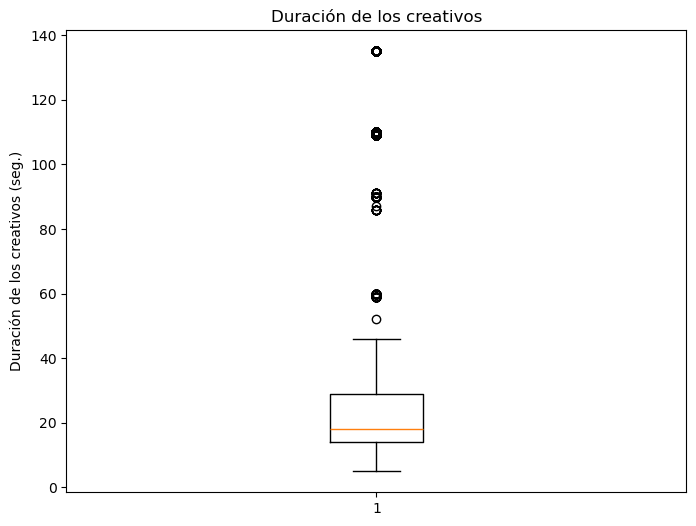

In [13]:
# Establecer el tamaño de la figura
plt.figure(figsize=(8, 6))

# Crear el boxplot 
plt.boxplot(df['creative_duration'])

# Establecer el título y etiquetas de los ejes
plt.title('Duración de los creativos')
plt.ylabel('Duración de los creativos (seg.)')
plt.show()


#### Seaborn

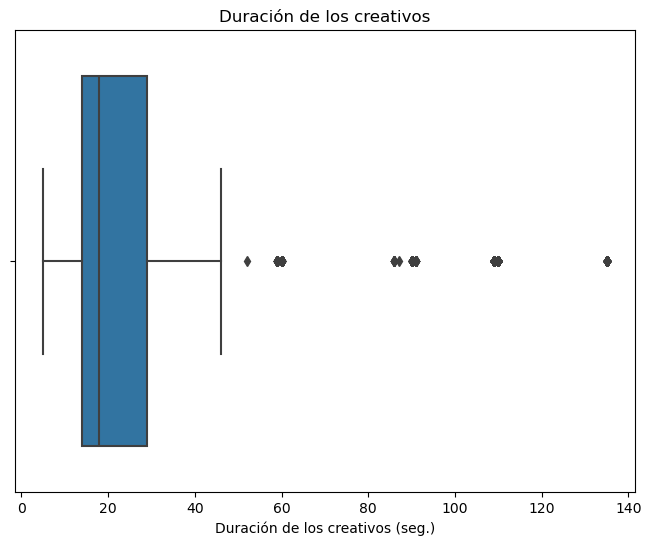

In [14]:
# Establecer el tamaño de la figura
plt.figure(figsize=(8, 6))

# Crear el boxplot 
sns.boxplot(x=df['creative_duration'])

# Establecer el título y etiquetas de los ejes
plt.title('Duración de los creativos')
plt.xlabel('Duración de los creativos (seg.)')
plt.show()

### Data cleansing

Con el objetivo de mantener la integridad del análisis y de las visualizaciones, vamos a deshacernos de las impresiones donde la duración del creativo excede los 45 segundos.

In [15]:
df = df[df.creative_duration <= 45]

### Histograma de Engagement

Un primer análisis sobre el dataset puede ser la distribución del engagement. Si bien podríamos discriminar esa distribución en función de casi cualquier variable categórica, en este caso lo haremos por tipo de dispositivo.

Como se puede visualizar en los dos graficos siguientes la mayor parte de los usuarios no llega a los 5 segundos de reproducción, por lo que se hace crítico optimizar esta métrica, ya que es uno de los mayores influenciadores en el revenue de la industria.

#### Matplotlib

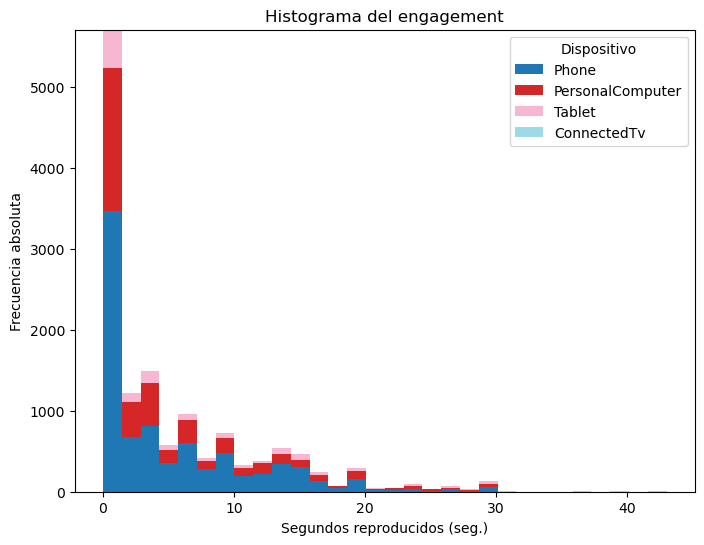

In [16]:
# Calcular el total de ocurrencias para cada dispositivo y revertir el orden para que las más frecuentes aparezcan abajo
device_order = df['ua_device'].value_counts().index

# Definir los intervalos
bins = np.linspace(df['seconds_played'].min(), df['seconds_played'].max(), 31)

# Preparar los datos del histograma para cada dispositivo
hist_data = {device: np.histogram(df[df['ua_device'] == device]['seconds_played'], bins=bins)[0] for device in device_order}

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar las barras apiladas
bottom = np.zeros(len(bins) - 1)
colors = plt.cm.tab20(np.linspace(0, 1, len(device_order)))  # Generar una paleta de colores

for device, color in zip(device_order, colors):
    ax.bar(bins[:-1], hist_data[device], width=np.diff(bins), align='edge', label=device, bottom=bottom, color=color)
    bottom += hist_data[device]

# Título y etiquetas
ax.set_title('Histograma del engagement')
ax.set_xlabel('Segundos reproducidos (seg.)')
ax.set_ylabel('Frecuencia absoluta')
ax.legend(title='Dispositivo')
ax.grid(False)

# Mostrar la gráfica
plt.show()

#### Seaborn

c:\Users\thega\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\thega\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
c:\Users\thega\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\thega\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1057: FutureWarnin

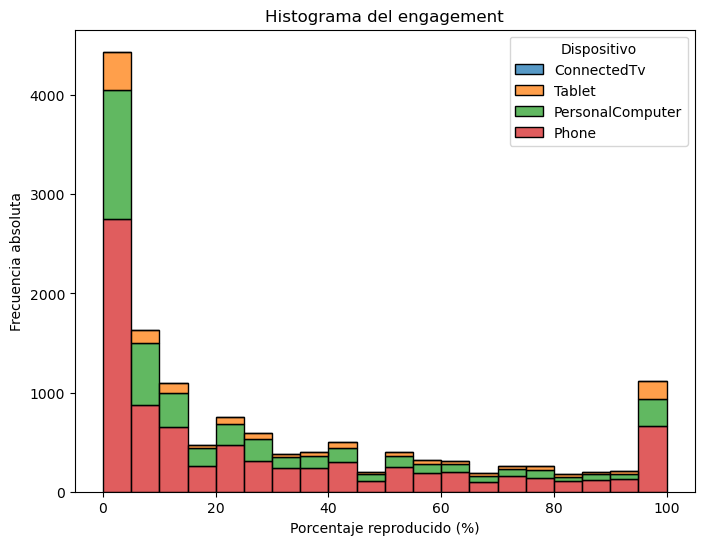

In [17]:
# Calcular el total de ocurrencias para cada dispositivo y revertir el orden
device_order = df['ua_device'].value_counts().index[::-1]

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(8, 6))

# Crear el histograma con el orden de matiz ordenado
sns.histplot(data=df, x='completion_percentage', bins=20, ax=ax, hue='ua_device', multiple='stack', hue_order=device_order)

# Establecer el título y las etiquetas
ax.set_title('Histograma del engagement')
ax.set_xlabel('Porcentaje reproducido (%)')
ax.set_ylabel('Frecuencia absoluta')

# Actualizar el título de la leyenda
leg = ax.get_legend()
leg.set_title('Dispositivo')

# Mostrar la gráfica
plt.show()


### Completion Rate por dispositivo y por sistema operativo

Otro análisis interesante puede ser la distribución del engagement a través de los diferentes dispositivos y sistemas operativos donde se ubican estos espacios publicitarios. Esto se debe a que tanto el dispositivo como el sistema operativo que utiliza el usuario representan una buena heurísitica de las actividades que realiza y, por ende, de cuánto tiempo puede invertir mirando un anuncio.

#### Influencia del dispositivo (Matplotlib):

A continuación utilizaremos Matplotlib para analizar el Completion Rate en función del dispositivo del usuario. Se puede apreciar que los anuncios impresos en tablets tienen mejor engagement que los otros. Además, los anuncios mostrados en TVs son los que menos engagement generan.

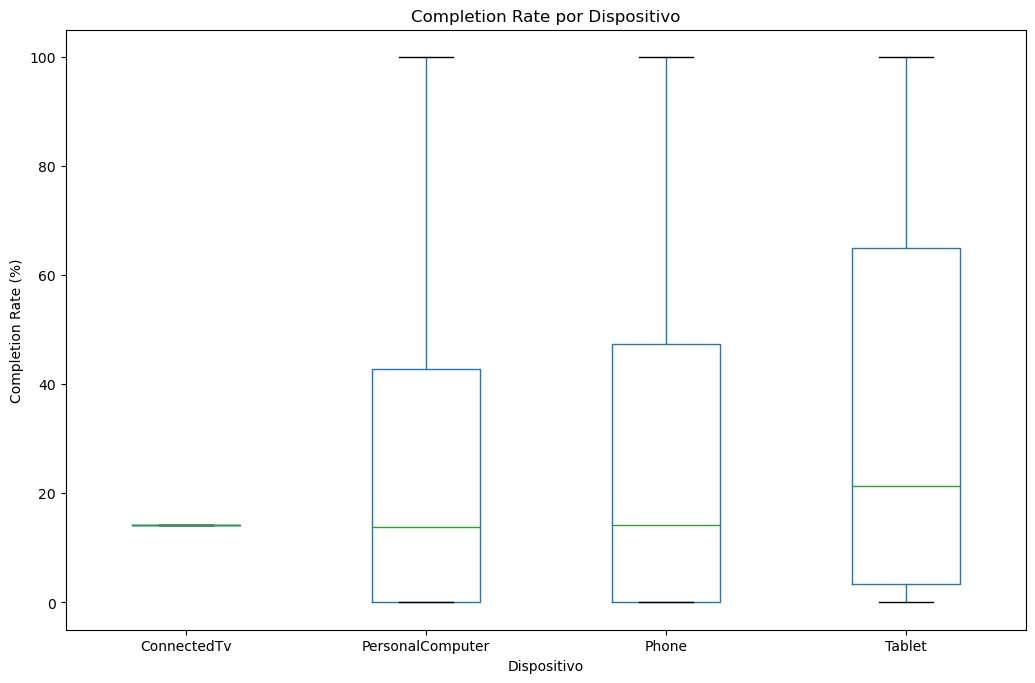

In [18]:
# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(12, 8))

# Crear el boxplot
df.boxplot(column='completion_percentage', by='ua_device', ax=ax)

# Configurar etiquetas y título
ax.set_title('Completion Rate por Dispositivo')
ax.set_xlabel('Dispositivo')
ax.set_ylabel('Completion Rate (%)')

# Eliminar el título automático generado por `boxplot`
plt.suptitle('')
plt.grid(False)

# Mostrar el gráfico
plt.show()


#### Influencia del sistema operativo (Seaborn):

A continuación haremos un análisis casi igual al anterior sólo que en lugar de analizar el engagement en función del dispositivo, lo haremos en función del sistema operativo y utilizaremos Seaborn, sólo por variar de herramienta. En este gráfico podemos apreciar cómo los sistemas operativos más rentables (en términos publicitarios, claro está) son iOS, Linux, Windows y Android.

Otro dato interesante es que los espacios publicitarios de los cuales desconocemos el SO son los que mejor engagement presentan. Si tuvieramos acceso a la fuente de los datos podríamos investigar de qué sistema operativo están llegando estas impresiones.

c:\Users\thega\miniconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


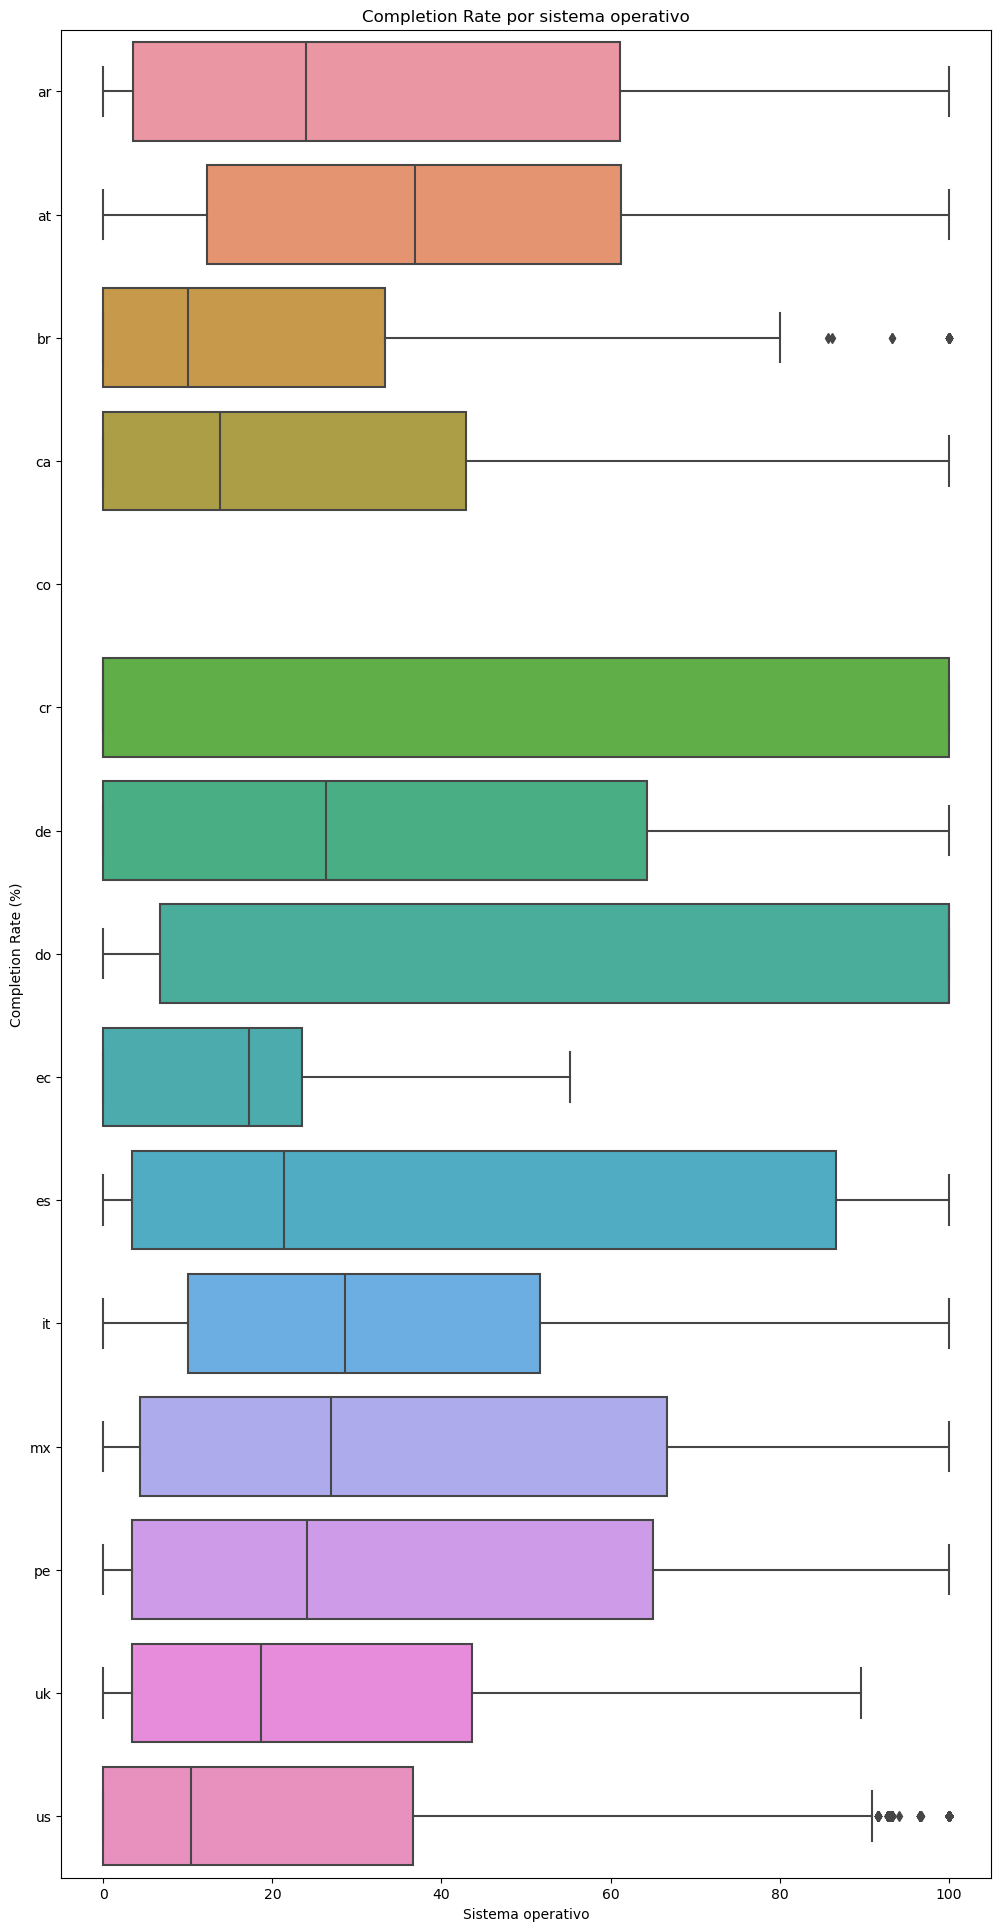

In [19]:
# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(12, 24))

# Crear el boxplot
sns.boxplot(data=df, y='ua_country', x='completion_percentage', ax=ax, orient='h')

# Configurar etiquetas y título
ax.set_title('Completion Rate por sistema operativo')
ax.set_xlabel('Sistema operativo')
ax.set_ylabel('Completion Rate (%)')

# Mostrar el gráfico
plt.show()


### Estacionalidad de las impresiones

Las impresiones de anuncios en diferentes aplicaciones o sitios dependen del uso que le dan los usuarios a esas aplicaciones o sitios. Como podemos ver en el siguiente análisis la mayor cantidad de impresiones se genera entre las 17hs y las 3hs de la madrugada. Podemos discriminarlas por tipo de dispositivo para tener una visualización más detallada.

#### Matplotlib

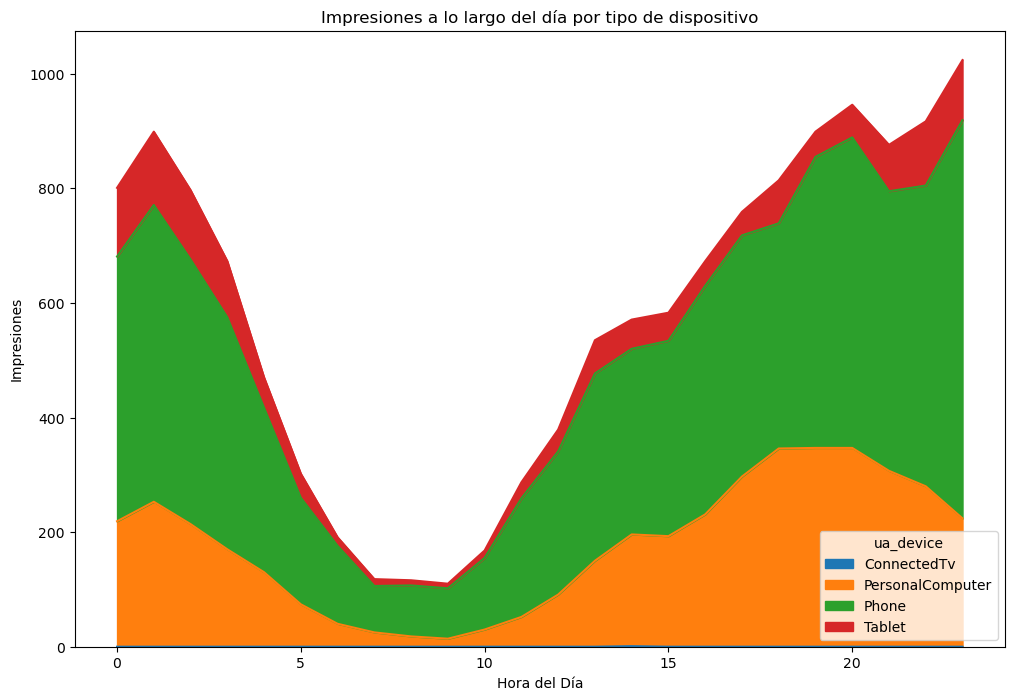

In [20]:
# Agrupar los datos por hora y lenguaje de ubicación
grouped = df.groupby(['hour', 'ua_device'], observed=False)['auction_id'].count().unstack()

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(12, 8))

# Crear el stacked area chart
grouped.plot(kind='area', stacked=True, ax=ax)

# Configurar etiquetas y título
ax.set_title('Impresiones a lo largo del día por tipo de dispositivo')
ax.set_xlabel('Hora del Día')
ax.set_ylabel('Impresiones')

# Mostrar el gráfico
plt.show()


#### Seaborn

c:\Users\thega\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\thega\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\thega\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\thega\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

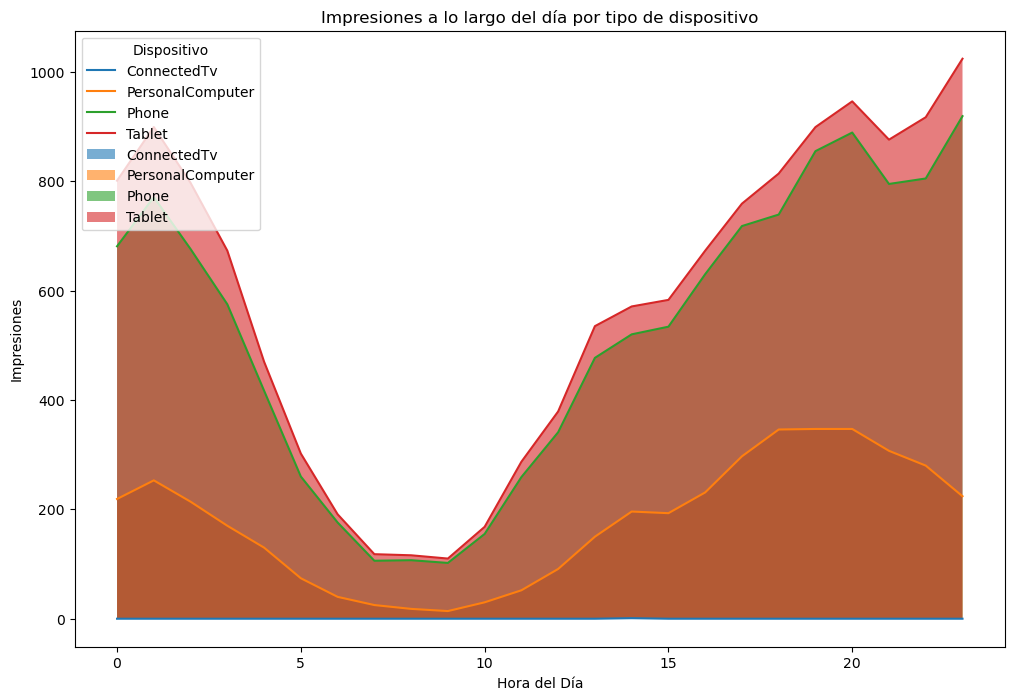

In [21]:
# Agrupar los datos por hora y dispositivo
grouped = df.groupby(['hour', 'ua_device'], observed=False)['auction_id'].count().unstack()

# Crear DataFrame acumulado
grouped_cumsum = grouped.cumsum(axis=1)

# Crear la figura y el eje
plt.figure(figsize=(12, 8))

# Crear el gráfico de curvas apiladas 
for column in grouped.columns:
    sns.lineplot(data=grouped_cumsum, x=grouped.index, y=grouped_cumsum[column], label=column)

# Pintar área bajo cada curva
for i, column in enumerate(grouped.columns):
    plt.fill_between(grouped.index, grouped_cumsum[column], label=column, alpha=0.6)

# Título y Etiquetas
plt.title('Impresiones a lo largo del día por tipo de dispositivo')
plt.xlabel('Hora del Día')
plt.ylabel('Impresiones')
plt.legend(title='Dispositivo', loc='upper left')

# Mostrar el gráfico
plt.show()



### Estacionalidad del engagement

El engagement también tiene su propia estacionalidad a lo largo del día, ya que el tiempo que dedica el usuario a ver un anuncio está influenciado por la actividad que está realizando en ese momento. Como podemos ver en el siguiente análisis, el mayor nivel de engagement lo tenemos entre las 8:00 y las 11:00 de la mañana con un extraño valle a las 9:00. Sería bueno investigar si ese valle es representativo de los datos de la industria o si sólo se debe a una particularidad de los datos muestreados en el dataset.

#### Matplotlib

c:\Users\thega\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\thega\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


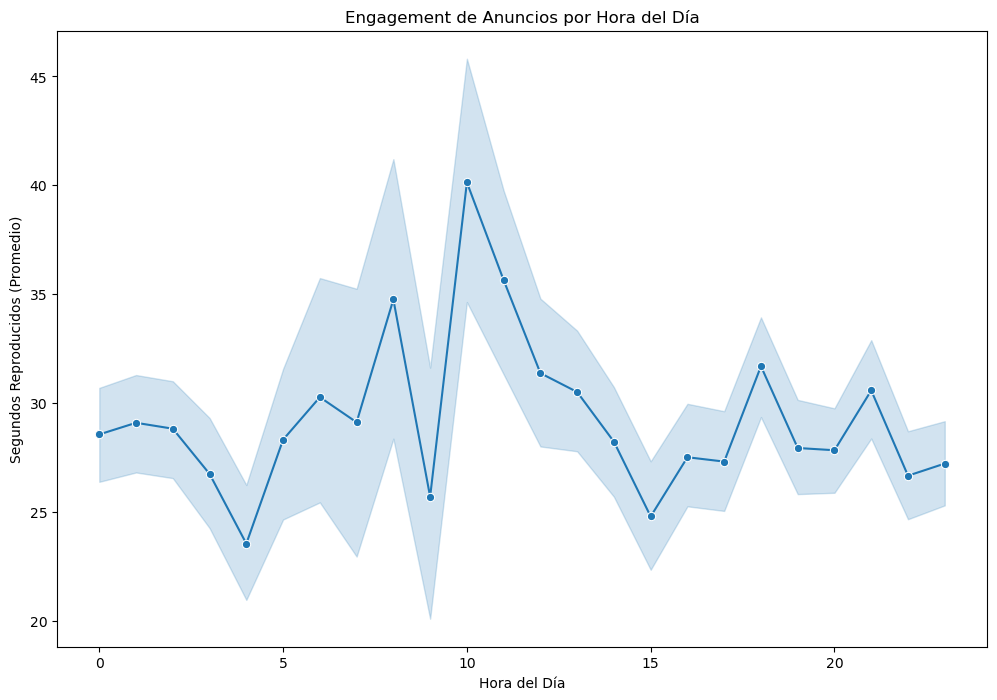

In [22]:
# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(12, 8))

# Crear el line plot
sns.lineplot(data=df, x='hour', y='completion_percentage', ax=ax, marker='o')

# Configurar etiquetas y título
ax.set_title('Engagement de Anuncios por Hora del Día')
ax.set_xlabel('Hora del Día')
ax.set_ylabel('Segundos Reproducidos (Promedio)')

# Mostrar el gráfico
plt.show()


#### Seaborn

C:\Users\thega\AppData\Local\Temp\ipykernel_28644\1183570874.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hourly_engagement = df.groupby('hour')['seconds_played'].mean().reset_index()
c:\Users\thega\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\thega\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


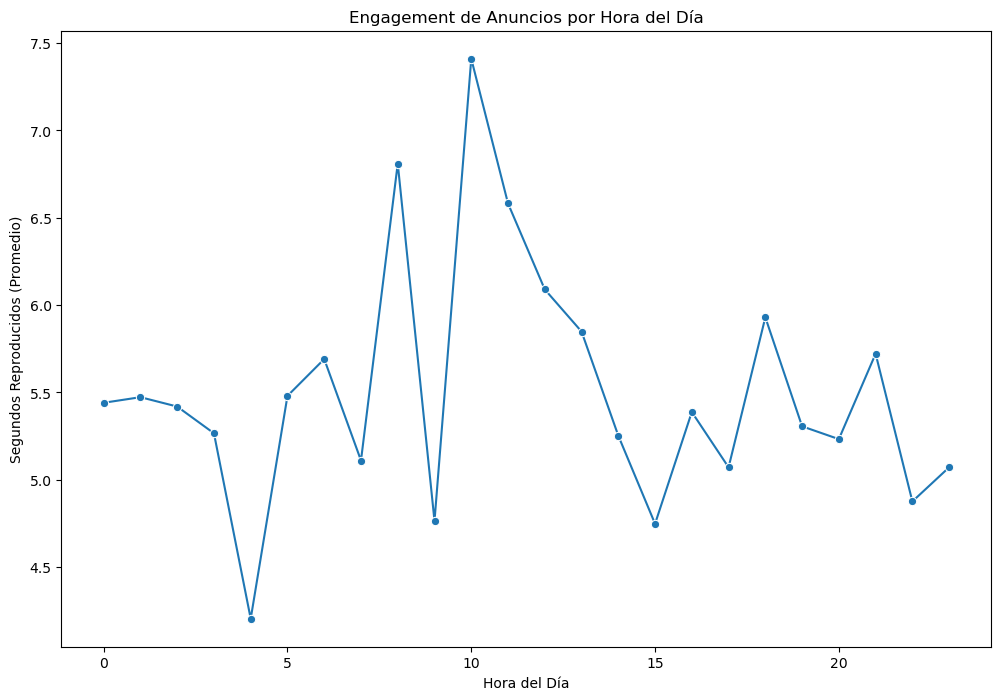

In [23]:
# Agrupar por hora y calcular el promedio de segundos reproducidos
hourly_engagement = df.groupby('hour')['seconds_played'].mean().reset_index()

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(12, 8))

# Crear el line plot
sns.lineplot(data=hourly_engagement, x='hour', y='seconds_played', ax=ax, marker='o')

# Configurar etiquetas y título
ax.set_title('Engagement de Anuncios por Hora del Día')
ax.set_xlabel('Hora del Día')
ax.set_ylabel('Segundos Reproducidos (Promedio)')

# Mostrar el gráfico
plt.show()

### Porcentaje de compleción en función de la duración del creativo

Como dijimos antes, mientras más largo es un video, se supone que menor es la probabilidad de que lo veamos completo. A continuación hacemos un análisis del porcentaje de compleción en función de la duración del anuncio.

Si bien podemos ver que los videos más largos tienen muy pocas ocurrencias donde el usuario ha visualizado más de la mitad del mismo, para los videos de menor duración (menos de 30 segundos) no se visualizan patrones claros de influencia entre estas dos variables.

In [24]:
# Calcular la frecuencia de ocurrencias para cada par de creative_duration y completion_percentage
frequency_df = df.groupby(['creative_duration', 'completion_percentage']).size().reset_index(name='frequency')

# Normalizar los tamaños para que estén entre 10 y 500
min_size = 10
max_size = 500
sizes = np.interp(frequency_df['frequency'], (frequency_df['frequency'].min(), frequency_df['frequency'].max()), (min_size, max_size))


#### Matplotlib

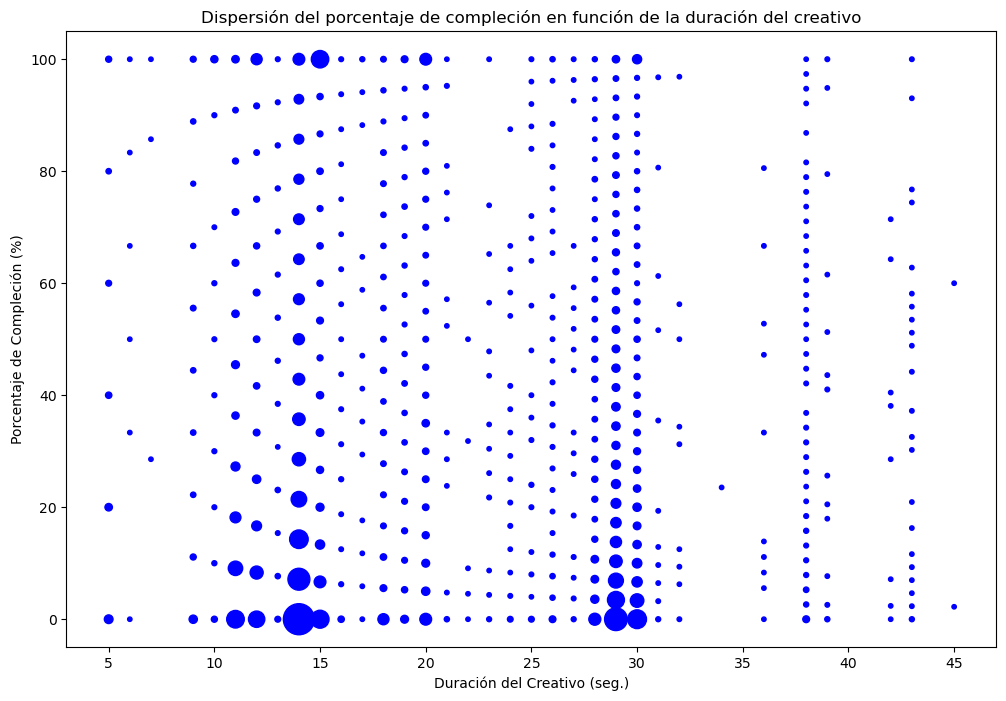

In [25]:
# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(12, 8))

# Crear el scatterplot
scatter = ax.scatter(
    frequency_df['creative_duration'], 
    frequency_df['completion_percentage'], 
    s=sizes, 
    color='blue'  
)

# Titulo y etiquetas 
ax.set_title('Dispersión del porcentaje de compleción en función de la duración del creativo')
ax.set_xlabel('Duración del Creativo (seg.)')
ax.set_ylabel('Porcentaje de Compleción (%)')

# Mostrar el gráfico
plt.show()

#### Seaborn

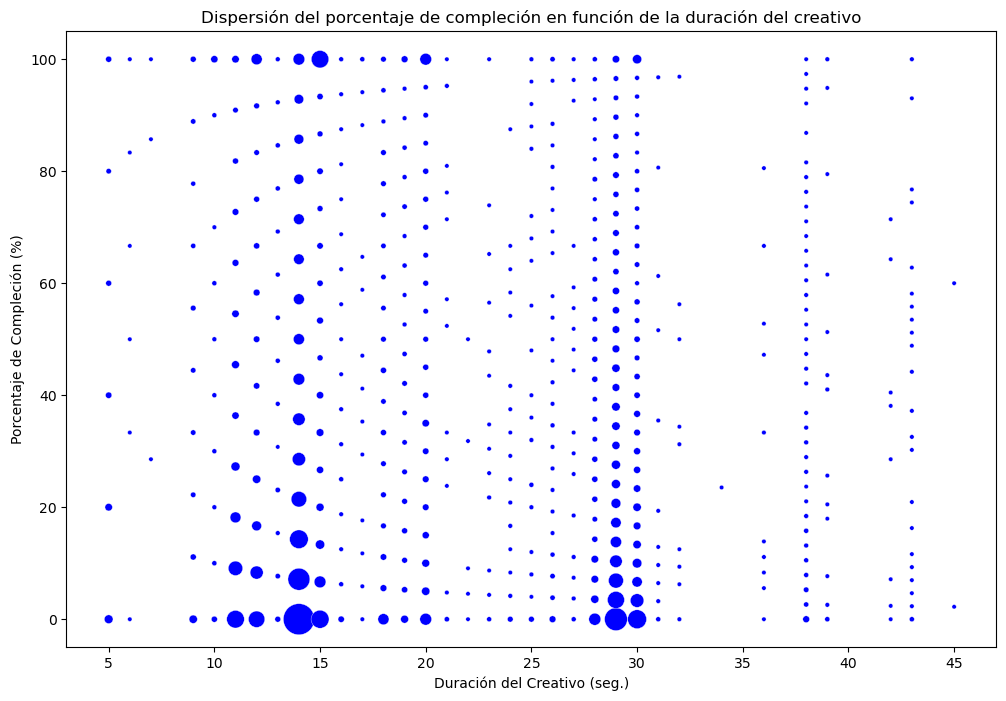

In [26]:
frequency_df['sizes'] = sizes

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(12, 8))

# Crear el scatterplot con Seaborn
sns.scatterplot(
    data=frequency_df, 
    x='creative_duration', 
    y='completion_percentage', 
    size='sizes', 
    legend=False, 
    sizes=(min_size, max_size),
    color='blue'  # Establecer un solo color para todos los puntos
)

# Establecer etiquetas y título
ax.set_title('Dispersión del porcentaje de compleción en función de la duración del creativo')
ax.set_xlabel('Duración del Creativo (seg.)')
ax.set_ylabel('Porcentaje de Compleción (%)')

# Mostrar el gráfico
plt.show()

### Conclusiones del EDA

A partir de la investigación de la industria de la publicidad programática podemos deducir la importancia de la optimización de la métrica correspondiente al engagement para maximizar la rentabilidad de las campañas publicitarias.

Ante las particularidades del dataset, nos vemos en la necesidad de eliminar columnas con demasiados valores nulos y de imputar algunos valores en columnas con algunos valores nulos pero relativamente pocos.

Dado el formato del archivo del dataset, también nos vemos en la necesidad de convertir los datos a tipos que nos permitan manipularlos con mayor facilidad.

Algunas dimensiones del dataset presentan ciertos outliers que deforman el análisis y es necesario eliminarlos en pos de preservar la significancia estadística de los datos.

De la visualización de los datos podemos sacar algunas conclusiones, como por ejemplo que la mayoría de los usuarios no llega a ver los primeros 5 segundos del anuncio antes de cerrarlo y, dado que el Completion Rate es una métrica clave no sólo para medir la performance de las campañas publicitarias sino también para cobrar por ellas, es que su optimización es de suma relevancia.

Otra conclusión temprana que podemos inferir a partir de una primera visualización de los datos es la influencia que tienen tanto el dispositivo como el sistema operativo a la hora de hacer una segmentación cuasi demográfica de los usuarios, entendiendo que representan una buena heurística del engagement que muestran ante los anuncios impresos.

Por otra parte, algunas visualizaciones muestran la clara estacionalidad que maneja la industria a lo largo del día en relación no sólo a la cantidad de impresiones sino también del engagement de las mismas.

Para finalizar, se destaca la clara influencia de la duración de los creativos en el porcentaje de compleción que presentan los mismos, sobre todo en creativos de más de 30 segundos. Extrañamente, esa influencia no se visualiza en creativos más cortos, algo que en lo que se puede seguir indagando en un análisis futuro.

## Estudio de Modelos Analíticos

Hay varios modelos analíticos que podemos utilizar dependiendo de cuál sea el objetivo, que a su vez dependerá del modelo de negocio que estemos aplicando.

El dataset no contiene información acerca del costo de cada impresión. Éste puede ser fijo o bien, estar sujeto a una subasta automatizada (protocol Real Time Bidding). Ya que no tenemos esta información, podemos hacer algunos supuestos cuando lo necesitemos a fin de simplificar el ejercicio. 

Por ejemplo, asumamos por un momento que estamos comprando impresiones con un precio fijo. Si nuestro modelo de negocio implica cobrar por reproducciones completas, sólo nos interesa comprar aquellas impresiones que tengan probabilidades de ser reproducidas en su totalidad y descartar el resto. En este caso tenemos un problema de clasificación binaria: completos e incompletos. Podríamos utilizar árboles de decisión, KNN o una regresión logística.

Si, por el contrario, nuestro modelo de negocio implica cobrar por cada segundo reproducido, nuestra variable a optimizar no es el porcentaje de compleción sino la cantidad de segundos reproducidos. Esto modificará el comportamiento del modelo, sobre todo en relación a los creativos de mayor duración que, si bien pueden ser más propensos a reproducir mayor cantidad de segundoss, son menos propensos a ser reproducidos en su totalidad.

### Regresión

Dado que el tiempo de reproducción es una variable contínua, este caso es más idóneo para un modelo de regresión. Empezaremos por este caso.

#### Features Selection

Primero seleccionaremos las variables más influyentes para no sobrecargar el modelo con dimensiones que no tienen incidencia

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Eliminamos la columna referer_deep_three y auction_id
df.drop(columns=['referer_deep_three', 'auction_id'], inplace=True, errors='ignore')

# Seleccionamos las columnas categóricas y numéricas
categorical_features = [
    'creative_id', 'campaign_id', 'advertiser_id', 'placement_id', 'website_id', 
    'placement_language', 'ua_country', 'ua_os', 'ua_browser', 'ua_device'
]
numeric_features = ['creative_duration']

# Aplicamos One-Hot Encoding a las variables categóricas
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categories = encoder.fit_transform(df[categorical_features])
encoded_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(categorical_features))

# Concatenamos las variables numéricas originales y las variables categóricas codificadas
df_encoded = pd.concat([df[numeric_features].reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Definimos la variable objetivo y las features
X = df_encoded
y = df['seconds_played']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos un modelo de Árbol de Decisión
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Obtenemosr la importancia de las features
importances = model.feature_importances_
features = X.columns

# Creamos un DataFrame para visualizar las importancias
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False).head(50)
print(feature_importances)


                                Feature  Importance
0                     creative_duration    0.062274
1094                          ua_os_iOS    0.041472
1103           ua_browser_Chrome Mobile    0.030108
1121           ua_browser_Safari mobile    0.025807
1126                    ua_device_Phone    0.023919
1105            ua_browser_Facebook App    0.023401
1127                   ua_device_Tablet    0.018501
864                  advertiser_id_8707    0.017216
1115  ua_browser_Mobile Samsung Browser    0.017081
1106                 ua_browser_Firefox    0.014513
1102                  ua_browser_Chrome    0.014042
1108              ua_browser_Google App    0.013733
1093                      ua_os_Windows    0.012409
1098         ua_browser_Android webview    0.011467
1037                   website_id_30353    0.010597
1095                        ua_os_macOS    0.010024
1092                         ua_os_OS X    0.009385
1113          ua_browser_Microsoft Edge    0.009254
676         

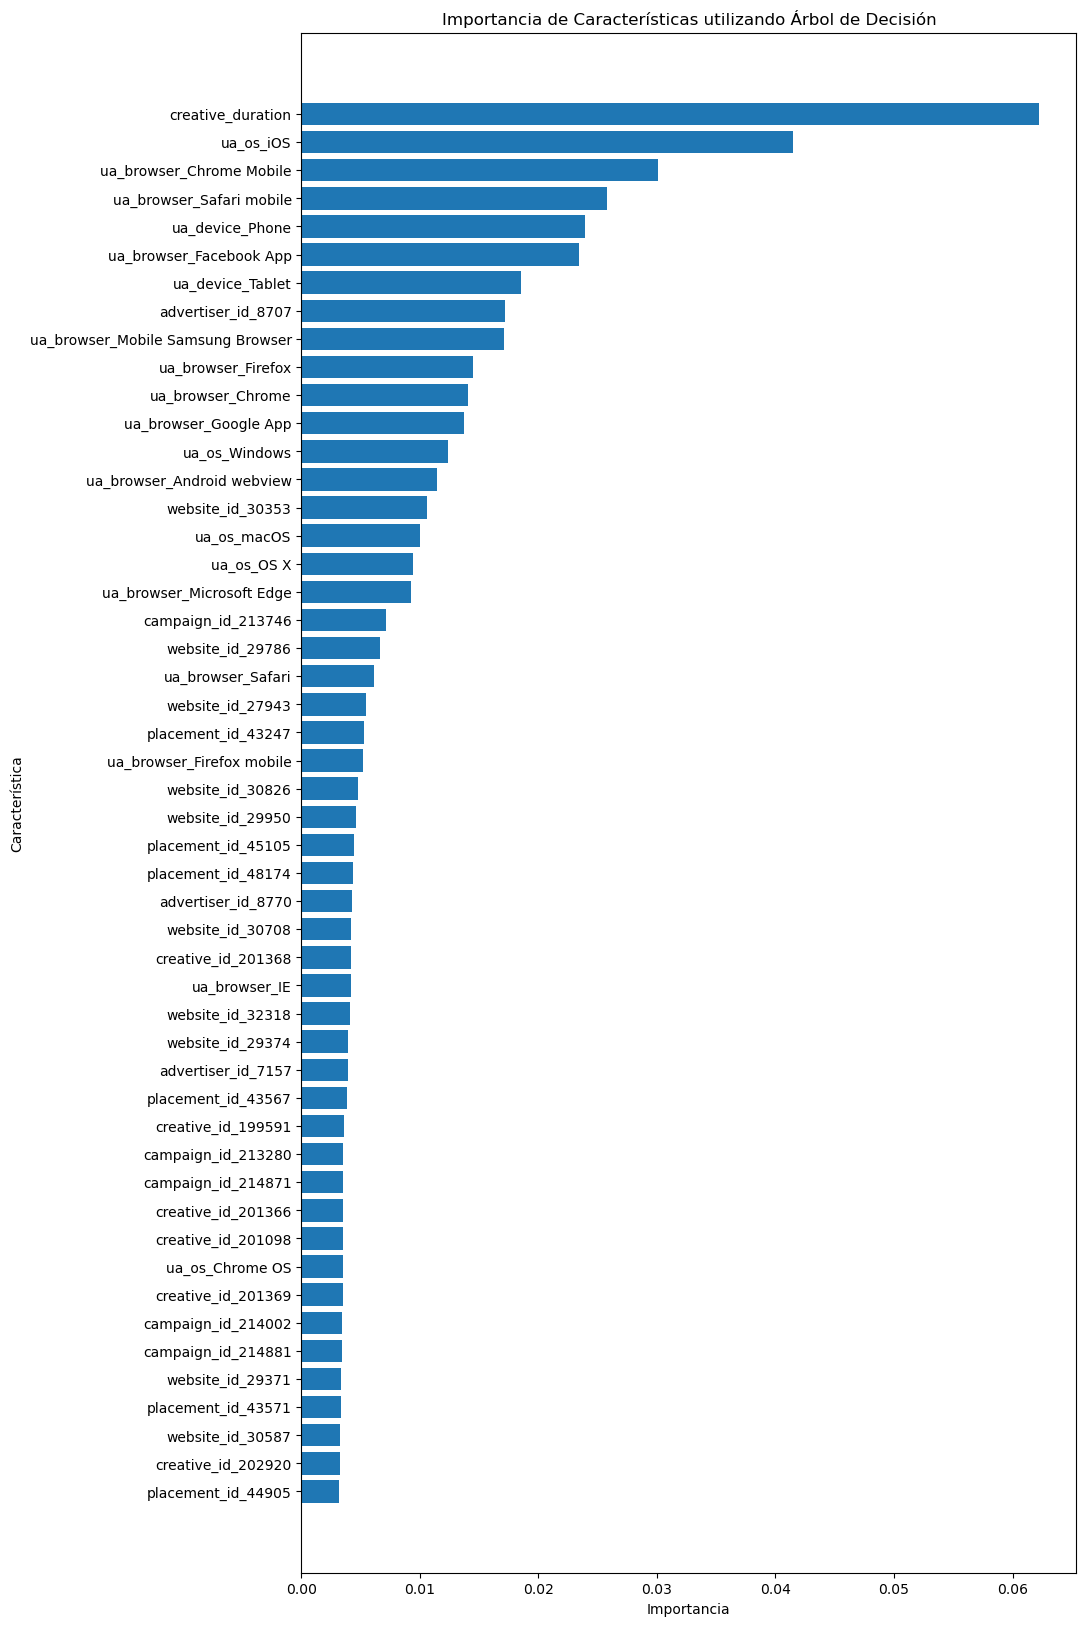

In [28]:

# Visualización de las importancias de features
plt.figure(figsize=(10, 20))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Importancia de Características utilizando Árbol de Decisión')
plt.gca().invert_yaxis()
plt.show()


Del análisis anterior resolvemos eliminar algunas variables como campaign_id, creative_id, placement_id, ya que tienen demasiados valores posibles y muy poca incidencia


In [46]:
# Eliminamos las columnas que no vamos a utilizar en el modelo
df.drop(columns=['referer_deep_three', 'auction_id'], inplace=True, errors='ignore')

# Definimos el objetivo y las features
target = 'seconds_played'  
features = df.columns.drop([
    'seconds_played', 
    'is_completed',
    'completion_percentage', 
    'campaign_id', 
    'ConvertedDateTime'])  

# Separamos las features y la variable objetivo
X = df[features]
y = df[target]

# Identificamos las features categóricas
categorical_features = [
    #'creative_id', 
    #'advertiser_id', 
    #'placement_id', 
    'website_id', 
    'ua_os', 
    'ua_browser', 
    'ua_device',
    'placement_language',
    'ua_country'
]

#### Regresión Lineal

En primera instancia intentaremos predecir la cantidad de segundos que el usuario verá el anuncio antes de cerrarlo. Para ello utilizaremos una regresión lineal múltiple.

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Codificamos las features categóricas con One-Hot Encoding
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' 
)
X_encoded = column_transformer.fit_transform(X)

# Dividimos los datos en conjuntos de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Inicializamos y entrenamos el modelo de Regresión Lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Realizamos predicciones en el conjunto de test
y_pred = model.predict(X_test)

# Evaluamos el modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared: {r2}')

results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results.head(30).round(0))


Mean Squared Error: 36.920498151312664
Root Mean Squared Error (RMSE): 6.076224004372507
R-squared: 0.1001758026169316
       Actual  Predicted
3841        0        3.0
8265        3        5.0
14325       5        7.0
10213      12        8.0
7566        2        3.0
13762       3        4.0
2642       10        3.0
1363        0        7.0
2707        0       11.0
10544      20        8.0
9597        0        5.0
14898      20       10.0
12113       0        3.0
1353        3        7.0
2828       14        7.0
5583        6        2.0
3150        1        7.0
11368       0       10.0
12686       7        6.0
1508        5        5.0
10285       1        3.0
7763        3        6.0
1858        3        3.0
178         0        4.0
11499       2        2.0
6695        7        4.0
11522       1        4.0
14878       0        4.0
6365       23        5.0
1457        2        1.0


En principio la regresión lineal arroja predicciones bastante pobres por lo que intentaremos otro tipo de regresión.

#### Árbol de Regresión

In [49]:
from sklearn.tree import DecisionTreeRegressor

# Dividimos los datos en conjuntos de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# inicializamos y entrenamos el árbol de regesión
dt_regressor = DecisionTreeRegressor(random_state=42, max_depth=7)
dt_regressor.fit(X_train, y_train)

# Hacemos predicciones sobre el conjunto de test
y_pred = dt_regressor.predict(X_test)

#  Evaluamos el modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared: {r2}')

Mean Squared Error: 37.20393285911562
Root Mean Squared Error (RMSE): 6.09950267309685
R-squared: 0.0932679486813196


Después de algunos intentos, encontramos que la profundidad óptima de árbol es igual a 7. De todas formas la performance del modelo es peor que la regresión lineal y sigue estando muy lejos de ser aceptable. Intentaremos una regresión con Random Forest.

#### Rergresión con Random Forest

In [52]:
from sklearn.ensemble import RandomForestRegressor

#Inicializamos y entrenamos el modelo
rf_model = RandomForestRegressor(n_estimators=10, random_state=42)
rf_model.fit(X_train, y_train)

# Hacemos predicciones sobre el conjunto de test
y_pred = rf_model.predict(X_test)

# Evaluamos el modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (Random Forest): {mse}')
print(f'Root Mean Squared Error (RMSE) (Random Forest): {rmse}')
print(f'R-squared (Random Forest): {r2}')

results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

Mean Squared Error (Random Forest): 44.866718134210764
Root Mean Squared Error (RMSE) (Random Forest): 6.698262321991486
R-squared (Random Forest): -0.09348900084906298


En este caso, no sólo obtenemos un error cuadrático medio mayor a los anteriores sino que también obtenemos un valor R-cuadrado negativo, lo que nos indica que el modelo performa incluso peor que uno que simplemente prediga la media de los valores observados.

Dado que ninguna de las regresiones que intentamos parece dar resultados aceptables, intentaremos abordar el problema como uno de clasificación con el objetivo de predecir si el usuario llegará a ver el anuncio completo o lo cerrará antes.

### Clasificación
Intentaremos tratarlo como un problema de clasificación en el cual el objetivo será predecir si el usuario verá o no el anuncio en su totalidad. Para ello utilizaremos diversos métodos.

#### Árbol de Decisión

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2563
           1       0.27      0.21      0.24       219

    accuracy                           0.89      2782
   macro avg       0.60      0.58      0.59      2782
weighted avg       0.88      0.89      0.89      2782

Matriz de Confusión:
[[2437  126]
 [ 173   46]]


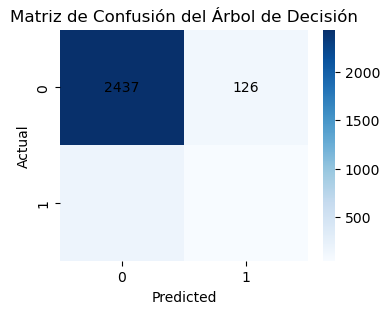

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Separamos las features y la variable objetivo 
y = df['is_completed']

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Inicializamos y entrenamos el modelo de Árbol de Decisión
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Realizamos predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Reporte de performance del modelo
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

# Visualización de la matriz de confusión
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", annot_kws={'color': 'black'})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión del Árbol de Decisión')
plt.show()



Si bien el accuracy del modelo es del 90% al parecer es bueno acertando verdaderos negativos pero no verdaderos positivos. Intentaremos con KNN.

#### KNN

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2563
           1       0.39      0.16      0.22       219

    accuracy                           0.91      2782
   macro avg       0.66      0.57      0.59      2782
weighted avg       0.89      0.91      0.90      2782

Matriz de Confusión:
[[2510   53]
 [ 185   34]]


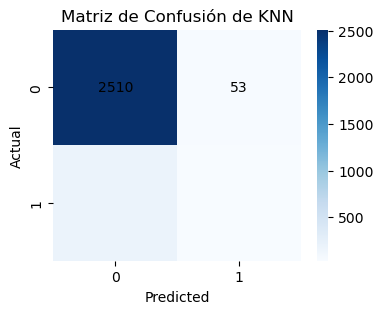

In [55]:
from sklearn.neighbors import KNeighborsClassifier

# Inicializamos y entrenamos el modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=5)  # Es el mejor N que pude encontrar
knn_model.fit(X_train, y_train)

# Realizamos predicciones en el conjunto de prueba
y_pred = knn_model.predict(X_test)

# Reporte de performance del modelo
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

# Visualización de la matriz de confusión
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", annot_kws={'color': 'black'})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión de KNN')
plt.show()


Hay una muy leve mejora de la performance pero la predicción de negativos pero la cantidad de verdaderos positivos sigue siendo muy pobre. Por último intentaremos con una regresión logística.

#### Regresión Logística

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2563
           1       0.60      0.08      0.14       219

    accuracy                           0.92      2782
   macro avg       0.76      0.54      0.55      2782
weighted avg       0.90      0.92      0.90      2782

Matriz de Confusión:
[[2551   12]
 [ 201   18]]


c:\Users\thega\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


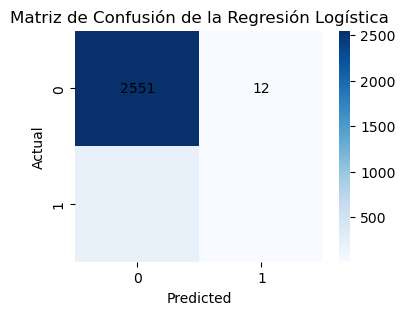

In [57]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

# Inicializamos y entrenamos el modelo de Regresión Logística
logreg_model = LogisticRegression(max_iter=500, random_state=42)  # Aumentamos max_iter para asegurar convergencia
logreg_model.fit(X_train, y_train)

# Realizamos predicciones en el conjunto de prueba
y_pred = logreg_model.predict(X_test)

# Reporte de performance del modelo
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

# Visualización de la matriz de confusión
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", annot_kws={'color': 'black'})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión de la Regresión Logística')
plt.show()


## Conclusiones

Después de algunos intentos de regresión no se encontró un modelo que pueda predecir la cantidad de segundos que el usuario verá el anuncio antes de cerrarlo. Esto se puede deber a que las variables independientes no tienen suficiente relación con la variable objetivo o a que el dataset no contiene datos suficientes como para asegurar la significancia estadística del comportamiento de la industria. Otra opción, por supuesto, puede ser que simplemente ninguno de los modelos utilizados en este trabajo se ajuste al tipo de problema.

En cuanto a los modelos de regresión, todos cuentan en mayor o menor medida con el mismo problema: Los casos negativos son significativamente superiores a los positvos, por lo que, si a esto sumamos la débil relación entre las variables independientes y la variable objetivo, es esperable que todos generen una buena cantidad de verdaderos negativos pero al mismo tiempo un porcentaje bajo de verdaderos positivos en relación a los falsos negativos. Dicho de otra forma, es fácil predecir cuándo el usuario cerrará el anuncio antes de verlo entero pero es muy difícil predecir cuándo verá el anuncio completo antes de cerrarlo.

De esto se desprende que no se puede demostrar el cumplimiento de la hipótesis planteada en un principio y al menos con este dataset no se puede predecir la cantidad de segundos que los usuarios reproducirán el anuncio antes de cerrarlo ni la probabilidad de que un anuncio sea reproducido en forma completa.